In [31]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import softmax

def Hbeta(D=np.array([]), beta=1.0):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    if sumP == 0:
        sumP = 1e-12  # Избегаем деления на ноль
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4
    P = np.maximum(P, 1e-12)
    return P

def tsne(X=np.array([]), no_dims=2, perplexity=30.0, max_iter=1000):
    (n, d) = X.shape
    max_iter = int(max_iter)
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4
    P = np.maximum(P, 1e-12)

    for iter in range(max_iter):
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1 / (1 + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        PQ = P - Q

        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((np.sign(dY) != np.sign(iY)) + (np.sign(dY) == np.sign(iY)) * 0.8)
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if iter % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        if iter == 100:
            P = P / 4

    return Y


In [37]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
Y = tsne(X, no_dims=2, perplexity=30.0, max_iter=301)

Iteration 1: error is 22.475748
Iteration 101: error is 12.938108
Iteration 201: error is 0.861931
Iteration 301: error is 0.750073


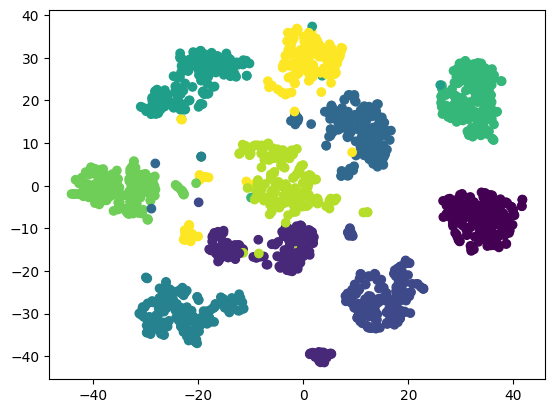

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y[:, 0], Y[:, 1], c=digits.target)
plt.show()